# Data Importing

In [1]:
import pandas as pd
from joblib import load

file = load('data_clean.z')
train_ts = file['train']
val_ts = file['val']
test_ts = file['test']

# Preprocessing
Similar to other machine learning approaches, the time-series must be transformed to a supervised learning dataset with an input feature vector/matrix and a target output vector/matrix. There are however some differences specific to neural networks, mainly:
* **Stationarity**: De-trending and de-seasonalizing are not necessarily required for neural network (NN) models. The NN model is the most similar to statistical linear regression methods in comparison with other machine learning approaches. The main advantage over statistical linear regression is that NNs expand the linear mathematical model to capture nonlinear components as well. Thus some users argue that their NN models should be left to learn trends in the time-series on their own, while others argue that statistical decomposition increases model performance.
* **3D input**: Specifically with recurrent neural network methods, the input should be reshaped to a 3 domensional matrix for representing: samples x time-steps x features
* **Normalization:** It has been proven that neural networks are more efficient when the data are normalized. This is because the initial weights are set very close to zero. In this exercise, normalizaiton is ignored. 

In line with the observations from the auto-correlation analysis, transform the data shape to include:
* Periodic cycle of 24 time steps
* Correlations up to 2 lagged cycles
* correlations up to 3 lagged time-steps

In [34]:
import numpy as np

train_ts_processed = train_ts.to_frame()
for l in [1,2,3,24,48]:
    train_ts_processed['lag-{}'.format(l)] = train_ts_processed['cpc'].shift(periods=l)
train_ts_processed.dropna(inplace=True, axis=0)
y = train_ts_processed['cpc'].values
X = train_ts_processed.drop('cpc', axis=1).values.reshape(train_ts_processed.shape[0], 5, 1)
print('feature matrix:\n',X)
print('Target vector:\n',y.reshape(-1,1))

feature matrix:
 [[[0.06554477]
  [0.06290964]
  [0.05719088]
  [0.11795615]
  [0.08196474]]

 [[0.05671602]
  [0.06554477]
  [0.06290964]
  [0.09097692]
  [0.09897224]]

 [[0.05876072]
  [0.05671602]
  [0.06554477]
  [0.08432432]
  [0.06531395]]

 ...

 [[0.09746742]
  [0.09390159]
  [0.10585349]
  [0.1116204 ]
  [0.07905245]]

 [[0.1039746 ]
  [0.09746742]
  [0.09390159]
  [0.11521015]
  [0.08909928]]

 [[0.10010288]
  [0.1039746 ]
  [0.09746742]
  [0.08847783]
  [0.08012475]]]
Target vector:
 [[0.05671602]
 [0.05876072]
 [0.05987885]
 ...
 [0.1039746 ]
 [0.10010288]
 [0.09344961]]


# Model Setting Up
Using Keras (https://keras.io/), which is a TensorFlow's high-level API for neural networks (https://www.tensorflow.org), the neural network is set up sequentially. This also allows stacking up different types of layers on top of each others (e.g. recurrent layer on top of MLP layer). This also includes defining the output layer which includes the results. 'Deep Learning' refers to having multiple layers stacked on top of each others, so a single layer NN does not qualify as 'Deep Learning'. The following are some considerations when setting up an RNN-LSTM model for time-series:
* The output layer can be defined so that it produces a single time-step, or multi-timestep forecasts (seq2seq).
* IF an RNN layer is defined as stateful, it preserves the internal state  across batches, opposed to reseting the state for each batch.
* Statefulness is not preserved within the batch, so to have completed dependency, batch size should be set to 1
* Each layer must be correctly set to return the desired output, whether it output a sequence or not.
* The way batches are fed into the model can be either randomized (e.g. shuffled) or fed in order. The latter is more suitable for time-series forecast problems.
* These models can train continuously (i.e. on-line training) as more data become available.

Set up a 'deep' RNN-LSTM model with the following settings:
* Take inputs in batches of 1 observation at a time
* first hidden LSTM layer with 10 nodes, Relu activation, and statefulness
* second hidden LSTM layer with 10 nodes (this makes it 'deep'), Relu activation, and statefulness
* output layer (Dense) creates only a single output (single-step forecast):

In [28]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense

bs = 1
model = Sequential()
model.add(LSTM(10, activation='relu', batch_input_shape=(bs, 5, 1), stateful=True, return_sequences=True))
model.add(LSTM(10, activation='relu', input_shape=(5, 1), stateful=True, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Learning
Train the model for 3 epochs:

In [29]:
model.fit(X, y, batch_size=bs, epochs=10, shuffle=False, verbose=1)

Epoch 1/10
1011/1011 [==============================] - 36s 36ms/step - loss: 9.3838e-04
Epoch 2/10
1011/1011 [==============================] - 34s 34ms/step - loss: 6.0068e-04
Epoch 3/10
1011/1011 [==============================] - 33s 33ms/step - loss: 5.0695e-04 0s - loss: 5.03
Epoch 4/10
1011/1011 [==============================] - 35s 34ms/step - loss: 4.4176e-04
Epoch 5/10
1011/1011 [==============================] - 35s 34ms/step - loss: 3.6697e-04
Epoch 6/10
1011/1011 [==============================] - 34s 33ms/step - loss: 3.0328e-04
Epoch 7/10
1011/1011 [==============================] - 33s 32ms/step - loss: 2.8482e-04
Epoch 8/10
1011/1011 [==============================] - 33s 32ms/step - loss: 2.7504e-04
Epoch 9/10
1011/1011 [==============================] - 33s 32ms/step - loss: 2.7244e-04
Epoch 10/10
1011/1011 [==============================] - 32s 32ms/step - loss: 2.7314e-04


Notice how the loss stopped declining after few iterations. No further convergence.

# Forecasting
Since the trained model outputs only one-step forecast, then the output can be fed back into the model as a new input to obtain the subsequent observations on a rolling-bases.

In this example, conduct the forecast on a rolling basis:

In [30]:
from datetime import timedelta

forecasts = pd.DataFrame(columns=train_ts_processed.columns, index=val_ts.index)
attached_df = pd.concat([train_ts_processed[-48:], forecasts], axis=0)
for t in forecasts.index:
    for l in [1,2,3,24,48]:
        forecasts.loc[t, 'lag-{}'.format(l)] = attached_df.loc[t - timedelta(hours=l), 'cpc']
    step_X = forecasts.loc[t].values[1:].reshape(1,5,1)
    step_y = model.predict(step_X, batch_size=bs)[0][0]
    attached_df.loc[t, 'cpc'], forecasts.loc[t, 'cpc'] = step_y, step_y

forecasts.head()

,cpc,lag-1,lag-2,lag-3,lag-24,lag-48
timestamp,,,,,,
2011-08-14 03:00:00,0.105557,0.0934496,0.100103,0.103975,0.0781188,0.0816735
2011-08-14 04:00:00,0.1202,0.105557,0.0934496,0.100103,0.0926107,0.10848
2011-08-14 05:00:00,0.132405,0.1202,0.105557,0.0934496,0.105254,0.123552
2011-08-14 06:00:00,0.149551,0.132405,0.1202,0.105557,0.147014,0.123781
2011-08-14 07:00:00,0.178529,0.149551,0.132405,0.1202,0.184961,0.154624


# Validation
Compare forecasts against the hold-out validation set

Text(0.5, 1.0, 'MSE: 0.007697996877826925')

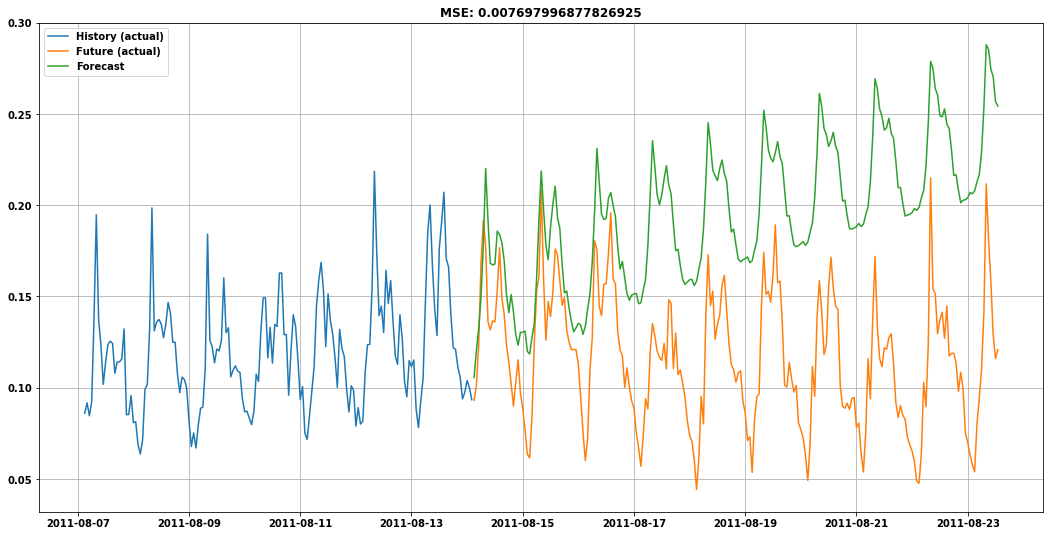

In [31]:
import matplotlib.pyplot as plt

mse = ((val_ts.values - forecasts['cpc'].values)**2).mean()

plt.figure(figsize=(18,9))
plt.plot(train_ts[-24*7:], label='History (actual)')
plt.plot(val_ts, label='Future (actual)')
plt.plot(forecasts['cpc'], label='Forecast')
plt.legend()
plt.grid()
plt.title('MSE: '+ str(mse))

In general, the accuracy of the one-step ahead forecast problem declines for longer forecast periods, although it is clear that the neural network had learned the cyclic pattern (24 hr seasonality). Several things may have gone wrong, including:
* The problem may have been ill defined: batch size and input shape
* Removing the trend might help (differencing or seasonal-differencing)
* Neural network design (e.g. layers, neurons, activation, statefulness, etc.)
* Longer training period required (epochs)
* Data scale (normalziation or standardization)
* For long term forcasting with seasonal data, seq2seq might be better
* Hyper-parameter optimization